In [1]:
# read the file "regressor_tolerance/t_0.1.txt" as list of rows
# and plot the data
import matplotlib.pyplot as plt
import numpy
import numpy as np


# read the file

def get_mixing(param_str):
    tokens = param_str.split(" ")
    for token in tokens:
        if "W:" in token:
            return float(token.split(":")[1])

def get_tpred_fixed(param_str):
    tokens = param_str.split(" ")
    for token in tokens:
        if "TPredFixed:" in token:
            new_token = token.replace("Norm:", " orm:")
            val = new_token.split(" ")[0].split(":")[1]
            return float(val) if val != "None" else None
    

def squeeze(tokens):
    output_tokens = []
    for token in tokens:
        if token == "":
            continue

        output_tokens.append(token.strip(" "))
    return output_tokens


def parse_line(line):
    bt_or_weak, metric_name, metric_token = line.strip().split(":")
    assert bt_or_weak in ["BT Removed", "Weak Ch Pred"]
    ch1_token, ch2_token = squeeze(metric_token.split('\t'))
    ch1_val, ch1_se = map(float, ch1_token.split("+-"))
    ch2_val, ch2_se = map(float, ch2_token.split("+-"))
    return {
        'state':bt_or_weak, 
        'metric_name':metric_name, 
        'value':[ch1_val, ch2_val], 
        'se': [ch1_se, ch2_se]
    }


def parse_metric_values(metric_values, metric_name):
    assert len(metric_values) % 2 == 0
    bt_removed_values = []
    bt_removed_errors = []

    weak_ch_pred_values = []
    weak_ch_pred_errors = []
    for i in range(0, len(metric_values), 2):
        assert metric_values[i]['state'] == "BT Removed"
        assert metric_values[i+1]['state'] == "Weak Ch Pred"
        assert metric_values[i]['metric_name'].strip() == metric_name, f"{metric_values[i]['metric_name']} != {metric_name}"
        assert metric_values[i+1]['metric_name'].strip() == metric_name
        bt_removed_values.append(metric_values[i]['value'])
        bt_removed_errors.append(metric_values[i]['se'])
        weak_ch_pred_values.append(metric_values[i+1]['value'])
        weak_ch_pred_errors.append(metric_values[i+1]['se'])
    return {
        'bt_removed': [np.array(bt_removed_values), np.array(bt_removed_errors)],
        'weak_ch_pred': [np.array(weak_ch_pred_values), np.array(weak_ch_pred_errors)]
    }
def parse_file(filename, metric_name):
    # Weak Ch Pred: PSNR:	 25.42+-0.365	21.53+-1.159
    # Weak Ch Pred: MicroSSIM:	 0.749+-0.0220	0.508+-0.0380
    # Weak Ch Pred: MicroS3IM:	 0.853+-0.0140	0.585+-0.0280
    # Weak Ch Pred: SSIM:	 0.635+-0.0280	0.606+-0.0290
    # Weak Ch Pred: MSSSIM:	 0.802+-0.0150	0.598+-0.0350
    # Weak Ch Pred: lpips:	 0.211+-0.0180	0.455+-0.0330

    assert metric_name in ["PSNR", "MSSSIM", "lpips"]
    with open(filename, "r") as file:
        lines = file.readlines()
    psnr_lines = [line.strip('\n') for line in lines if "PSNR:" in line]
    ssim_lines = [line.strip('\n') for line in lines if "MSSSIM:" in line]
    lpips_lines = [line.strip('\n') for line in lines if "lpips:" in line]
    
    params = [line.strip('\n') for line in lines if "W:" in line]

    print("PSNR", psnr_lines[0])
    print("SSIM", ssim_lines[0])
    print("LPIPS", lpips_lines[0])
    print("Params", params[0])

    mixing_values = [get_mixing(param) for param in params]
    tpred_fixed_values = [get_tpred_fixed(param) for param in params]
    psnr_values = [parse_line(line) for line in psnr_lines]
    ssim_values = [parse_line(line) for line in ssim_lines]
    lpips_values = [parse_line(line) for line in lpips_lines]
    assert 2*len(mixing_values) == len(psnr_values) 
    assert 2*len(mixing_values)== len(ssim_values) 
    assert 2*len(mixing_values)==len(lpips_values)
    assert len(mixing_values)==len(tpred_fixed_values)
    values_dict = {
        'PSNR': psnr_values,
        'MSSSIM': ssim_values,
        'lpips': lpips_values
    }


    metric_dict = parse_metric_values(values_dict[metric_name], metric_name)
    bt_value, bt_err = metric_dict['bt_removed']
    wc_value, wc_err = metric_dict['weak_ch_pred']

    inp1_results = np.concatenate(  [bt_value[:,:1], wc_value[:,1:]], axis=1)
    inp1_err = np.concatenate(      [bt_err[:,:1], wc_err[:,1:]], axis=1)
    inp2_results = np.concatenate([wc_value[:,:1], bt_value[:,1:]], axis=1)
    inp2_err = np.concatenate(    [wc_err[:,:1], bt_err[:,1:]], axis=1)
    assert len(set(mixing_values)) == 1, f'One file should have only one mixing value, but found {set(mixing_values)}'
    return {'inp1_results':inp1_results,
            'inp2_results':inp2_results,
            'inp1_err':inp1_err,
            'inp2_err':inp2_err,
            'mixing_values':mixing_values[0],
            'tpred_fixed_values':tpred_fixed_values}



In [2]:
filename_01 = "regressor_tolerance/t_0.1.txt"
filename_02 = "regressor_tolerance/t_0.2.txt"
filename_03 = "regressor_tolerance/t_0.3.txt"
filename_04 = "regressor_tolerance/t_0.4.txt"
filename_05 = "regressor_tolerance/t_0.5.txt"
metric_name = "PSNR"
file01_metric = parse_file(filename_01, metric_name)
file02_metric = parse_file(filename_02, metric_name)
file03_metric = parse_file(filename_03, metric_name)
file04_metric = parse_file(filename_04, metric_name)
file05_metric = parse_file(filename_05, metric_name)

PSNR BT Removed: PSNR:	 40.04+-0.416	31.01+-2.262
SSIM BT Removed: MSSSIM:	 0.985+-0.0020	0.805+-0.0120
LPIPS BT Removed: lpips:	 0.007+-0.0010	0.155+-0.0150
Params T:10000 W:0.1 RealInp:False M:10 TPred:False TPredAgg:False TPredFixed:0.1Norm:10000 InfSteps:10000
PSNR BT Removed: PSNR:	 37.67+-0.303	31.53+-2.2
SSIM BT Removed: MSSSIM:	 0.981+-0.0020	0.811+-0.0120
LPIPS BT Removed: lpips:	 0.012+-0.0010	0.151+-0.0160
Params T:10000 W:0.2 RealInp:False M:10 TPred:False TPredAgg:False TPredFixed:0.1Norm:10000 InfSteps:10000
PSNR BT Removed: PSNR:	 36.12+-0.217	31.92+-2.121
SSIM BT Removed: MSSSIM:	 0.974+-0.0020	0.816+-0.0110
LPIPS BT Removed: lpips:	 0.019+-0.0020	0.144+-0.0150
Params T:10000 W:0.3 RealInp:False M:10 TPred:False TPredAgg:False TPredFixed:0.1Norm:10000 InfSteps:10000
PSNR BT Removed: PSNR:	 34.38+-0.271	32.08+-1.972
SSIM BT Removed: MSSSIM:	 0.959+-0.0030	0.827+-0.0100
LPIPS BT Removed: lpips:	 0.032+-0.0040	0.136+-0.0130
Params T:10000 W:0.4 RealInp:False M:10 TPred:Fal

In [3]:
outputdir = '/group/jug/ashesh/indiSplitResults/plots/'
save_plots=True

### Channel 1

Saving to /group/jug/ashesh/indiSplitResults/plots//regressor_tolerance_BioSR_PSNR_ch1.png


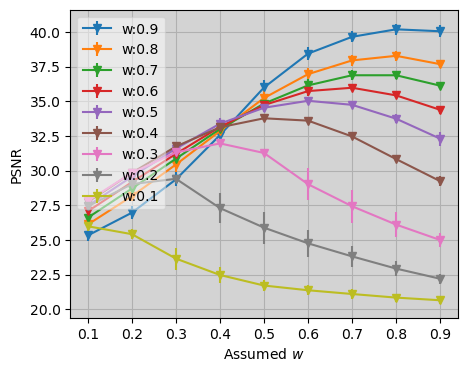

In [7]:
from matplotlib.ticker import FormatStrFormatter

_,ax = plt.subplots(figsize=(5,4))
marker = "v"
y = file01_metric['inp1_results'][::-1,0]
yerr = file01_metric['inp1_err'][::-1,0]
x = file01_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{1-file01_metric['mixing_values']}", marker=marker)

y = file02_metric['inp1_results'][::-1,0]
yerr = file02_metric['inp1_err'][::-1,0]
x = file02_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{1-file02_metric['mixing_values']}", marker=marker)

y = file03_metric['inp1_results'][::-1,0]
yerr = file03_metric['inp1_err'][::-1,0]
x = file03_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{1-file03_metric['mixing_values']}", marker=marker)

y = file04_metric['inp1_results'][::-1,0]
yerr = file04_metric['inp1_err'][::-1,0]
x = file04_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{1-file04_metric['mixing_values']}", marker=marker)

y = file05_metric['inp1_results'][::-1,0]
yerr = file05_metric['inp1_err'][::-1,0]
x = file05_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{1-file05_metric['mixing_values']}", marker=marker)








y = file04_metric['inp2_results'][::-1,0]
yerr = file04_metric['inp2_err'][::-1,0]
x = file04_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{file04_metric['mixing_values']}", marker=marker)

y = file03_metric['inp2_results'][::-1,0]
yerr = file03_metric['inp2_err'][::-1,0]
x = file03_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{file03_metric['mixing_values']}", marker=marker)



y = file02_metric['inp2_results'][::-1,0]
yerr = file02_metric['inp2_err'][::-1,0]
x = file02_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{file02_metric['mixing_values']}", marker=marker)



y = file01_metric['inp2_results'][::-1,0]
yerr = file01_metric['inp2_err'][::-1,0]
x = file01_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{file01_metric['mixing_values']}", marker=marker)




# enable grid
plt.grid()
# fill the background color to grey

plt.legend(framealpha=0.5, loc='upper left')
plt.gca().set_facecolor('lightgrey')
plt.ylabel(metric_name)
plt.xlabel("Assumed $w$")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
if save_plots:
    img_fpath = f"{outputdir}/regressor_tolerance_BioSR_{metric_name}_ch1.png"
    print(f"Saving to {img_fpath}")
    plt.savefig(img_fpath, dpi=150,
                bbox_inches='tight')

Saving to /group/jug/ashesh/indiSplitResults/plots//regressor_tolerance_BioSR_PSNR_ch2.png


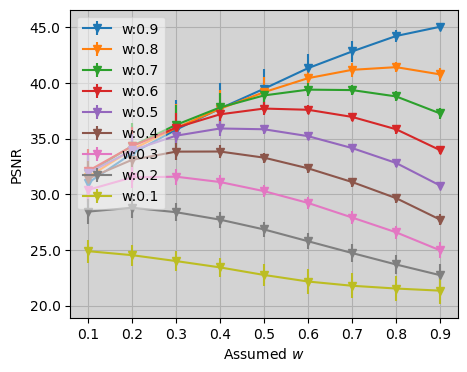

In [8]:

_,ax = plt.subplots(figsize=(5,4))

y = file01_metric['inp2_results'][:,1]
yerr = file01_metric['inp2_err'][:,1]
x = file01_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{1-file01_metric['mixing_values']}", marker=marker)

y = file02_metric['inp2_results'][:,1]
yerr = file02_metric['inp2_err'][:,1]
x = file02_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{1-file02_metric['mixing_values']}", marker=marker)

y = file03_metric['inp2_results'][:,1]
yerr = file03_metric['inp2_err'][:,1]
x = file03_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{1-file03_metric['mixing_values']}", marker=marker)

y = file04_metric['inp2_results'][:,1]
yerr = file04_metric['inp2_err'][:,1]
x = file04_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{1-file04_metric['mixing_values']}", marker=marker)










y = file05_metric['inp1_results'][:,1]
yerr = file05_metric['inp1_err'][:,1]
x = file05_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{file05_metric['mixing_values']}", marker=marker)

y = file04_metric['inp1_results'][:,1]
yerr = file04_metric['inp1_err'][:,1]
x = file04_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{file04_metric['mixing_values']}", marker=marker)

y = file03_metric['inp1_results'][:,1]
yerr = file03_metric['inp1_err'][:,1]
x = file03_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{file03_metric['mixing_values']}", marker=marker)

y = file02_metric['inp1_results'][:,1]
yerr = file02_metric['inp1_err'][:,1]
x = file02_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{file02_metric['mixing_values']}", marker=marker)

y = file01_metric['inp1_results'][:,1]
yerr = file01_metric['inp1_err'][:,1]
x = file01_metric['tpred_fixed_values']
plt.errorbar(x, y, yerr=yerr, label=f"w:{file01_metric['mixing_values']}", marker=marker)












# enable grid
plt.grid()
# fill the background color to grey

plt.legend(framealpha=0.5, loc='upper left')
plt.gca().set_facecolor('lightgrey')
plt.ylabel(metric_name)
plt.xlabel("Assumed $w$")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
if save_plots:
    img_fpath = f"{outputdir}/regressor_tolerance_BioSR_{metric_name}_ch2.png"
    print(f"Saving to {img_fpath}")
    plt.savefig(img_fpath, 
                dpi=150,bbox_inches='tight')

In [ ]:
break here

## Saving qualitative image

## Channel 0


In [103]:
from disentangle.core.tiff_reader import load_tiff
import os
metric_dict = file02_metric

actual_t = metric_dict['mixing_values']
pred_t_arr = metric_dict['tpred_fixed_values']
pred_dir_schema = '/group/jug/ashesh/indiSplit/predictions/2502_BioSR-joint_indi-l1_5/T-{actual_t}_MMSE-10_InferT-0_InferTAgg-0_FixedT-{pred_t}'


in_use_pred_t_arr = [0.8, 0.5, 0.2, 0.1]
metric_arr = []
pred_ch1_arr = []
pred_ch2_arr = []
for pred_t in in_use_pred_t_arr:
    arr_ch1_idx = pred_t_arr.index(round(1-pred_t,2))
    pred_ch1_dir = pred_dir_schema.format(actual_t=actual_t, pred_t=round(1-pred_t,2))
    ch1_metric = metric_dict['inp1_results'][arr_ch1_idx, 0]
    print(pred_ch1_dir, ch1_metric)
    pred_ch1 = load_tiff(os.path.join(pred_ch1_dir, 'bt_removed_pred.tif'))[...,0]
    pred_ch1_arr.append(pred_ch1)
    
print('')
for pred_t in in_use_pred_t_arr:    
    arr_ch2_idx = pred_t_arr.index(round(pred_t,2))
    pred_ch2_dir = pred_dir_schema.format(actual_t=actual_t, pred_t=round(pred_t,2))
    ch2_metric = metric_dict['inp2_results'][arr_ch2_idx, 1]
    print(pred_ch2_dir, ch2_metric)
    pred_ch2 = load_tiff(os.path.join(pred_ch2_dir, 'bt_removed_pred.tif'))[...,1]
    pred_ch2_arr.append(pred_ch2)
    # ch2_metric = metric_dict['inp2_results'][arr_ch2_idx, 1]
    
    # break

# 0.8 strength, see the performance on 0.8, 0.5, 0.2, 0.1


/group/jug/ashesh/indiSplit/predictions/2502_BioSR-joint_indi-l1_5/T-0.2_MMSE-10_InferT-0_InferTAgg-0_FixedT-0.2 38.27
/group/jug/ashesh/indiSplit/predictions/2502_BioSR-joint_indi-l1_5/T-0.2_MMSE-10_InferT-0_InferTAgg-0_FixedT-0.5 35.23
/group/jug/ashesh/indiSplit/predictions/2502_BioSR-joint_indi-l1_5/T-0.2_MMSE-10_InferT-0_InferTAgg-0_FixedT-0.8 28.16
/group/jug/ashesh/indiSplit/predictions/2502_BioSR-joint_indi-l1_5/T-0.2_MMSE-10_InferT-0_InferTAgg-0_FixedT-0.9 26.12

/group/jug/ashesh/indiSplit/predictions/2502_BioSR-joint_indi-l1_5/T-0.2_MMSE-10_InferT-0_InferTAgg-0_FixedT-0.8 41.42
/group/jug/ashesh/indiSplit/predictions/2502_BioSR-joint_indi-l1_5/T-0.2_MMSE-10_InferT-0_InferTAgg-0_FixedT-0.5 39.17
/group/jug/ashesh/indiSplit/predictions/2502_BioSR-joint_indi-l1_5/T-0.2_MMSE-10_InferT-0_InferTAgg-0_FixedT-0.2 34.02
/group/jug/ashesh/indiSplit/predictions/2502_BioSR-joint_indi-l1_5/T-0.2_MMSE-10_InferT-0_InferTAgg-0_FixedT-0.1 31.53


In [116]:
save_plots=True
ch_idx = 0


if ch_idx == 0:
    pred_ch_arr = pred_ch1_arr 
elif ch_idx ==1:
    pred_ch_arr = pred_ch2_arr
else:
    raise ValueError("Invalid ch_idx")

Saving to /group/jug/ashesh/indiSplitResults/plots//regressor_tolerance_BioSR_qualitative_ch1_pred_0x0x100x400x400.png


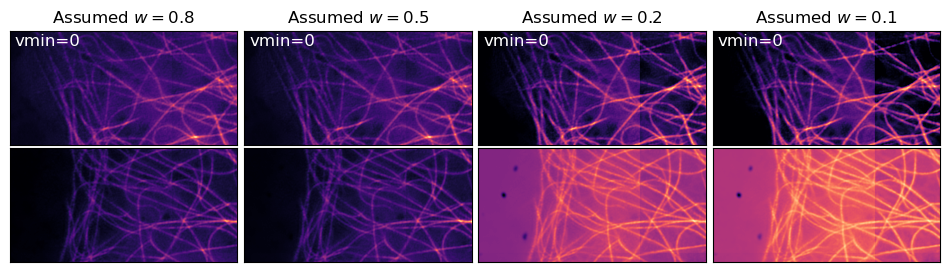

In [117]:
from disentangle.analysis.plot_utils import clean_ax
_,ax = plt.subplots(figsize=(12,3),ncols=4,nrows=2)
img_idx = 0
hs = 0 
ws = 100
sz = 400
ax[0,0].imshow(pred_ch_arr[0][img_idx, hs:hs+sz//2, ws:ws+sz], vmin=0, cmap='magma')
ax[0,1].imshow(pred_ch_arr[1][img_idx, hs:hs+sz//2, ws:ws+sz], vmin=0, cmap='magma')
ax[0,2].imshow(pred_ch_arr[2][img_idx, hs:hs+sz//2, ws:ws+sz], vmin=0, cmap='magma')
ax[0,3].imshow(pred_ch_arr[3][img_idx, hs:hs+sz//2, ws:ws+sz], vmin=0,cmap='magma')
# add text
ax[0,0].text(8, 25, 'vmin=0', color='white', fontsize=12)
ax[0,1].text(8, 25, 'vmin=0', color='white', fontsize=12)
ax[0,2].text(8, 25, 'vmin=0', color='white', fontsize=12)
ax[0,3].text(8, 25, 'vmin=0', color='white', fontsize=12)

ax[1,0].imshow(pred_ch_arr[0][img_idx, hs+sz//2:hs+sz, ws:ws+sz], cmap='magma')
ax[1,1].imshow(pred_ch_arr[1][img_idx, hs+sz//2:hs+sz, ws:ws+sz], cmap='magma')
ax[1,2].imshow(pred_ch_arr[2][img_idx, hs+sz//2:hs+sz, ws:ws+sz], cmap='magma')
ax[1,3].imshow(pred_ch_arr[3][img_idx, hs+sz//2:hs+sz, ws:ws+sz], cmap='magma')

clean_ax(ax)
plt.subplots_adjust(wspace=0.03, hspace=0.03)

ax[0,0].set_title(f'Assumed $w = {in_use_pred_t_arr[0]}$')
ax[0,1].set_title(f'Assumed $w = {in_use_pred_t_arr[1]}$')
ax[0,2].set_title(f'Assumed $w = {in_use_pred_t_arr[2]}$')
ax[0,3].set_title(f'Assumed $w = {in_use_pred_t_arr[3]}$')

if save_plots:
    img_fpath = f"{outputdir}/regressor_tolerance_BioSR_qualitative_ch{ch_idx+1}_pred_{img_idx}x{hs}x{ws}x{sz}x{sz}.png"
    print(f"Saving to {img_fpath}")
    plt.savefig(img_fpath, 
                dpi=150,bbox_inches='tight')



In [118]:
input_tar_dir = os.path.join(os.path.dirname(pred_dir_schema), f"InpVsTar_T-{metric_dict['mixing_values']}")
input_data = load_tiff(os.path.join(input_tar_dir, 'input.tif'))
target_data = load_tiff(os.path.join(input_tar_dir, 'target.tif'))

Saving to /group/jug/ashesh/indiSplitResults/plots//regressor_tolerance_BioSR_qualitative_ch1_input_0x0x100x400x400.png


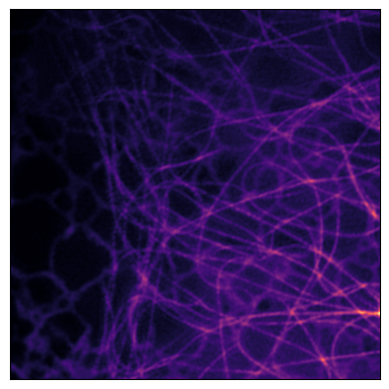

In [119]:
plt.imshow(input_data[img_idx, hs:hs+sz, ws:ws+sz,ch_idx], cmap='magma')
clean_ax(plt.gca())
if save_plots:
    img_fpath = f"{outputdir}/regressor_tolerance_BioSR_qualitative_ch{ch_idx+1}_input_{img_idx}x{hs}x{ws}x{sz}x{sz}.png"
    print(f"Saving to {img_fpath}")
    plt.savefig(img_fpath, 
                dpi=150,bbox_inches='tight')


Saving to /group/jug/ashesh/indiSplitResults/plots//regressor_tolerance_BioSR_qualitative_ch1_target_0x0x100x400x400.png


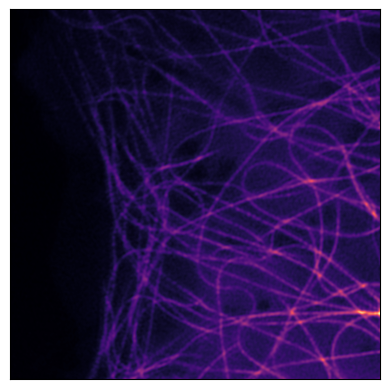

In [120]:
plt.imshow(target_data[img_idx, hs:hs+sz, ws:ws+sz,ch_idx], cmap='magma')
clean_ax(plt.gca())
if save_plots:
    img_fpath = f"{outputdir}/regressor_tolerance_BioSR_qualitative_ch{ch_idx+1}_target_{img_idx}x{hs}x{ws}x{sz}x{sz}.png"
    print(f"Saving to {img_fpath}")
    plt.savefig(img_fpath, 
                dpi=150,bbox_inches='tight')
